# **Navier-Stokes Equation and Fourier Neural Operators**

## **Navier-Stokes Equation in Vorticity Form**
The 2D incompressible Navier-Stokes equation in vorticity form is given by:

$$
\partial_t w(x,t) + u(x,t) \cdot \nabla w(x,t) = \nu \Delta w(x,t) + f(x),
$$

where:
- $w(x,t)$ is the vorticity,
- $u(x,t)$ is the velocity field satisfying incompressibility:
  $$
  \nabla \cdot u = 0.
  $$
- $\nu$ is the viscosity coefficient,
- $f(x)$ is the external forcing function.


## **Reference**
The Fourier Neural Operator (FNO) is a method introduced for learning parametric solutions to PDEs efficiently. For a detailed discussion, refer to:

**Li, Zongyi, et al.** "Fourier Neural Operator for Parametric Partial Differential Equations." *International Conference on Learning Representations (ICLR), 2021.*  
[Paper Link](https://arxiv.org/abs/2010.08895)

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from neuralop import get_model, LpLoss, H1Loss
from neuralop.training import Trainer, AdamW
from neuralop.utils import count_model_params
from neuralop.data.datasets import load_navier_stokes_pt
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [19]:
# ------------------------
# 1. SEEDING FOR REPRODUCIBILITY
# ------------------------
# Setting a fixed seed ensures that experiments are reproducible.
# This is important when training machine learning models to ensure consistent results.
torch.manual_seed(0)
np.random.seed(0)

In [20]:
# ------------------------
# 2. DATASET CONFIGURATION
# ------------------------
# The dataset consists of solutions to the 2D incompressible Navier-Stokes equation.
# These solutions are represented in vorticity form.
# Here, we specify the dataset parameters such as resolution and number of samples.
data_root = "/Users/xuhaohan/Desktop/neuraloperator-main/neuralop/data/datasets/data"  # Modify this path to your dataset location
train_resolution = 128  # Spatial resolution of training samples
test_resolutions = [128]  # Resolution of test samples (same as training for consistency)
n_train = 100  # Number of training samples
n_tests = [20]  # Number of test samples
batch_size = 8  # Batch size for training (higher batch size improves gradient estimation)
test_batch_sizes = [8] # Batch size for testing

In [21]:
# ------------------------
# 3. LOADING NAVIER-STOKES DATASET
# ------------------------
# The dataset consists of snapshots of fluid flow at different time steps.
# Each sample consists of:
#  - Input: Initial vorticity field.
#  - Output: Evolved vorticity field at a later time.
train_loader, test_loaders, data_processor = load_navier_stokes_pt(
    n_train=n_train,
    n_tests=n_tests,
    batch_size=batch_size,
    test_batch_sizes=test_batch_sizes,
    data_root=data_root,
    train_resolution=train_resolution,
    test_resolutions=test_resolutions,
    encode_input=True, # Normalize inputs using pre-defined transformation
    encode_output=True, # Normalize outputs using pre-defined transformation
)

Loading test db for resolution 128 with 20 samples 


In [22]:
# Display dataset statistics
print(f"Train dataset size: {len(train_loader.dataset)} samples")
for res, loader in test_loaders.items():
    print(f"Test dataset at resolution={res} has {len(loader.dataset)} samples")

Train dataset size: 100 samples
Test dataset at resolution=128 has 20 samples


In [23]:
# ------------------------
# 4. DEFINING THE FOURIER NEURAL OPERATOR (FNO) MODEL
# ------------------------
# Fourier Neural Operator (FNO) is a neural network architecture that solves PDEs
# by learning an operator in Fourier space.
# Instead of using local convolutions, it applies global convolution in the Fourier domain.
fno_config = {
    "data_channels": 1,  # Input: single-channel vorticity field
    "out_channels": 1,   # Output: single-channel vorticity field at future time
    "n_modes": [32, 32], # Number of Fourier modes used for each spatial dimension
    "hidden_channels": 64,  # Width of hidden layers in the FNO network
    "n_layers": 6,       # Depth: Number of Fourier layers
    "domain_padding": 0.0,  # Padding in Fourier domain (not used here)
    "fft_norm": "forward",  # Normalization used in FFT computation
    "norm": None,        # No additional normalization applied
    "skip": "linear",    # Skip connection type in FNO layers
    "implementation": "reconstructed",  # More memory-efficient implementation
}
# Initialize the FNO model
model = get_model({"arch": "fno", "fno": fno_config})


In [24]:
# Count the number of trainable parameters
n_params = count_model_params(model)
print(f"Model parameter count: {n_params}")

Model parameter count: 26806401


In [25]:
# ------------------------
# 5. SETTING UP THE TRAINING PROCESS
# ------------------------
# Move the model to the available device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [26]:
# Define optimizer and learning rate scheduler
# AdamW is a variant of Adam that improves generalization by using decoupled weight decay.
optimizer = AdamW(
    model.parameters(),
    lr=1e-3,  # Initial learning rate
    weight_decay=1e-4,  # Weight decay (L2 regularization)
)
# Reduce learning rate when validation loss plateaus
scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)  # Reduce by 50% if no improvement in 2 epochs

In [27]:
# ------------------------
# 6. DEFINING LOSS FUNCTIONS
# ------------------------
# - L2 loss (LpLoss with p=2) is used to measure pixel-wise differences.
# - H1 loss measures both the function and its first-order derivatives, capturing smoothness.
l2loss = LpLoss(d=2, p=2)  # Standard L2 loss (mean squared error)
h1loss = H1Loss(d=2)       # H1 loss, accounts for smoothness
train_loss = h1loss        # Use H1 loss for training
eval_losses = {"h1": h1loss, "l2": l2loss}  # Evaluate with both losses

In [28]:
# ------------------------
# 7. TRAINING LOOP
# ------------------------
trainer = Trainer(
    model=model,
    n_epochs=20,  # Number of training epochs
    data_processor=data_processor,
    device=device,
    mixed_precision=False,  # No mixed precision training
    eval_interval=1,  # Evaluate every epoch
    log_output=True,  # Log progress
    verbose=True,     # Print details
    wandb_log=False,  # Disable Weights & Biases logging
)

In [33]:
train_losses.clear()
val_losses.clear()
train_losses = []
val_losses = []

In [34]:
# Custom training loop for logging loss values
for epoch in range(trainer.n_epochs):
    
    model.train()
    epoch_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        x = batch["x"].to(device)
        y = batch["y"].to(device)
        out = model(x)
        loss = train_loss(out, y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    train_losses.append(epoch_train_loss / len(train_loader))

    # Validation phase
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for res, loader in test_loaders.items():
            for batch in loader:
                x = batch["x"].to(device)
                y = batch["y"].to(device)
                out = model(x)
                loss = eval_losses["l2"](out, y)  # Use L2 loss for validation
                epoch_val_loss += loss.item()
    val_losses.append(epoch_val_loss / len(test_loaders[test_resolutions[0]]))
    
    scheduler.step(epoch_val_loss) # Adjust learning rate if needed
    current_lr = scheduler.optimizer.param_groups[0]['lr']

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{trainer.n_epochs}: "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, "
          f"Learning Rate: {current_lr:.6f}")


Epoch 1/20: Train Loss: 2.0400, Val Loss: 1.7996, Learning Rate: 0.000500
Epoch 2/20: Train Loss: 1.9665, Val Loss: 1.8307, Learning Rate: 0.000250
Epoch 3/20: Train Loss: 1.9122, Val Loss: 1.5958, Learning Rate: 0.000250
Epoch 4/20: Train Loss: 1.7179, Val Loss: 1.5447, Learning Rate: 0.000250
Epoch 5/20: Train Loss: 1.5114, Val Loss: 1.5581, Learning Rate: 0.000250
Epoch 6/20: Train Loss: 1.4045, Val Loss: 1.5097, Learning Rate: 0.000250
Epoch 7/20: Train Loss: 1.3050, Val Loss: 1.5293, Learning Rate: 0.000250
Epoch 8/20: Train Loss: 1.2563, Val Loss: 1.5498, Learning Rate: 0.000250
Epoch 9/20: Train Loss: 1.2248, Val Loss: 1.5328, Learning Rate: 0.000125
Epoch 10/20: Train Loss: 1.1765, Val Loss: 1.6086, Learning Rate: 0.000125
Epoch 11/20: Train Loss: 1.1991, Val Loss: 1.5421, Learning Rate: 0.000125
Epoch 12/20: Train Loss: 1.1483, Val Loss: 1.4976, Learning Rate: 0.000125
Epoch 13/20: Train Loss: 1.0780, Val Loss: 1.4931, Learning Rate: 0.000125
Epoch 14/20: Train Loss: 1.0067, V

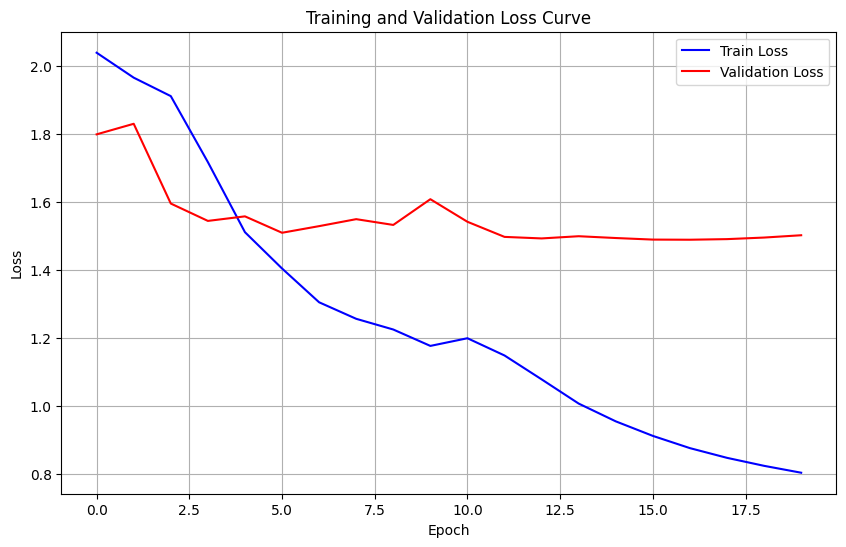

In [35]:
# ------------------------
# 8. PLOTTING TRAINING & VALIDATION LOSS
# ------------------------
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

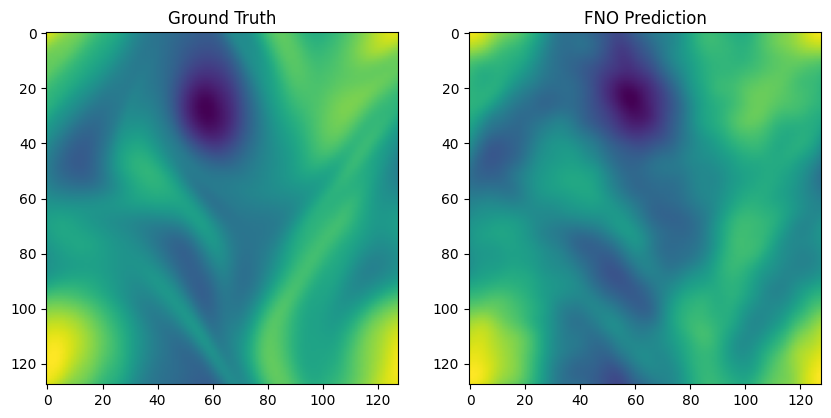

In [36]:
# ------------------------
# 9. VISUALIZING MODEL PREDICTIONS
# ------------------------
sample_batch = next(iter(test_loaders[test_resolutions[0]]))
x_in = sample_batch["x"].to(device)
with torch.no_grad():
    y_pred = model(x_in)
y_true = sample_batch["y"].to(device)
# Display the first sample's ground truth vs. model prediction
idx = 0 
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(y_true[idx, 0].cpu().numpy(), cmap="viridis")
axs[0].set_title("Ground Truth")
axs[1].imshow(y_pred[idx, 0].cpu().numpy(), cmap="viridis")
axs[1].set_title("FNO Prediction")
plt.show()

### **Results Analysis**

The training and validation loss curves in the first figure indicate a stable training process. This suggests the model is learning meaningful features from the data.

The second figure compares the **ground truth** (left) and the **Fourier Neural Operator (FNO) prediction** (right). The overall structure of the velocity field is well captured, showing the capability of the FNO in approximating solutions to the Navier-Stokes equations. However, some fine-scale details appear slightly smoothed in the predicted field.

Since the training dataset is relatively small and no **GPU acceleration** was used, the model's performance is constrained. Increasing the training data and utilizing **GPU-based acceleration** would likely enhance both accuracy and convergence speed.
